In [52]:
#Graph Gen 1.1 (27/03/2025)
# Added inputs and outputs
# The power consumption for a node ranges from 1 to 50 units and uniformly distributed.
# Plus the area may vary from 1 to 5 units as well, uniformly distributed
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import random

def generate_netlist(
    num_nodes=50,
    num_edges=100,
    enable_area=True,
    #Area (chip constraints) of the node or the gate assembly
    enable_power=True,
    # Power consumption of the gate (used to optimize or reduce heat generation or power consumption per chip)
    enable_wire_count=True,
    # Number of wires represented by an edge
    enable_distance=True,
    # Distance of the wire to calculate power dissipation and delay
    seed = 42
):
    """Generates a netlist as a graph with configurable node & edge attributes."""

    #Generate a directed graph
    G = nx.DiGraph()

    # Estimate number of inputs and outputs
    # Assuming num_inputs and num_outputs to be the functions below
    num_inputs = math.ceil(math.log2(num_nodes))
    num_outputs = math.ceil(num_inputs / 2)
    input_nodes = [f"IN_{i}" for i in range(num_inputs)]
    output_nodes = [f"OUT_{i}" for i in range(num_outputs)]


    # Create internal nodes
    for i in range(num_nodes):
        node_name = f"N_{i}"
        G.add_node(node_name)

        if enable_area:
            G.nodes[node_name]['area'] = round(random.uniform(1.0, 5.0), 2)
        if enable_power:
            G.nodes[node_name]['power'] = round(random.uniform(1.0, 50.0), 2)

    # Create input and output nodes
    for node in input_nodes + output_nodes:
        G.add_node(node)

    # Ensure the graph is connected using a spanning tree first
    all_nodes = input_nodes + [f"N_{i}" for i in range(num_nodes)]
    random.shuffle(all_nodes)
    for i in range(len(all_nodes) - 1):
        G.add_edge(all_nodes[i], all_nodes[i + 1])
        if enable_wire_count:
            G.edges[all_nodes[i], all_nodes[i + 1]]['wires'] = random.randint(1, 5)
        if enable_distance:
            G.edges[all_nodes[i], all_nodes[i + 1]]['distance'] = round(random.uniform(1.0, 10.0), 2)

    # Add additional random edges while keeping the graph connected
    existing_edges = set(G.edges())
    while len(G.edges()) < num_edges:
        u, v = random.sample(all_nodes, 2)
        if u != v and (u, v) not in existing_edges:
            G.add_edge(u, v)
            existing_edges.add((u, v))
            if enable_wire_count:
                G.edges[u, v]['wires'] = random.randint(1, 5)
            if enable_distance:
                G.edges[u, v]['distance'] = round(random.uniform(1.0, 10.0), 2)

    # Ensure each output node has at least one incoming connection
    for out_node in output_nodes:
        if G.in_degree(out_node) == 0:
            source_node = random.choice(all_nodes)
            G.add_edge(source_node, out_node)
            if enable_wire_count:
                G.edges[source_node, out_node]['wires'] = random.randint(1, 5)
            if enable_distance:
                G.edges[source_node, out_node]['distance'] = round(random.uniform(1.0, 10.0), 2)

    return G, input_nodes, output_nodes

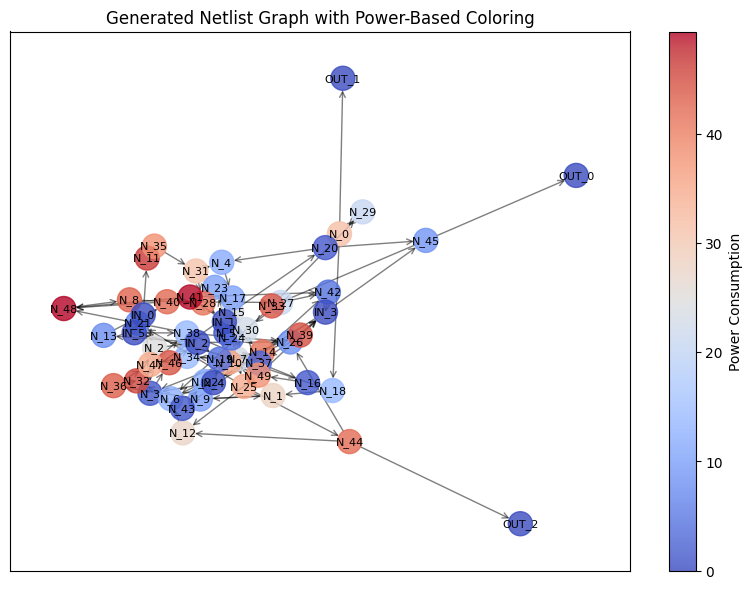

In [53]:
def visualize_netlist(G):
    pos = nx.spring_layout(G, seed=42)
    power_values = [G.nodes[n].get('power', 0) for n in G.nodes()]

    plt.figure(figsize=(10, 7))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=power_values, cmap='coolwarm', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Power Consumption")
    plt.title("Generated Netlist Graph with Power-Based Coloring")
    plt.show()

# Example usage
graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)
visualize_netlist(graph)


In [72]:
import random
from scipy.cluster.hierarchy import linkage, fcluster
import networkx as nx
import numpy as np
from scipy.spatial.distance import pdist, squareform, cityblock, mahalanobis
from scipy.linalg import inv

def calculate_power(G, u, v):
    # This function calculates power consumption for an edge (u, v) in the graph G by considering two factors:
    # 1. Node power: The sum of power consumption of both nodes u and v.
    # 2. Wire Power: The power consumed by the wire connecting u and v, which is product of distance and number of wires

    node_power = G.nodes[u].get('power', 0) + G.nodes[v].get('power', 0)
    wire_power = G.edges[u, v].get('distance', 1) * G.edges[u, v].get('wires', 1)
    return node_power + wire_power

def find_critical_path(G):
    # This function finds the critical path in the graph G based on the longest delay, where the delay is defined as L^2 (distance squared for each edge in the path)
    # This one uses Dijkstra’s Algorithm to find the shortest path from source to target (minimising distance)
    # Computes the delay as the sum of squares of edge distances, then returns the longest delay path and the corresponding maximum delay
    #Ways to improve -- If G is a DAG, then use Topological sorting + dP, and use bellman ford for G with negative weights

    longest_path = None
    max_delay = 0

    for source in G.nodes():
        for target in G.nodes():
            if source != target and nx.has_path(G, source, target):
                path = nx.shortest_path(G, source, target, weight='distance')
                path_delay = sum(G[u][v]['distance'] ** 2 for u, v in zip(path, path[1:]))
                if path_delay > max_delay:
                    max_delay = path_delay
                    longest_path = path

    return longest_path, max_delay

def perform_agglomerative_clustering(G, num_clusters=5):
    # This function clusters the nodes of a graph G using Agglomerative Clustering, while optimizing based on power and area constraints.
    # Performs Agglomerative Clustering using following methods
    # 1. complete: Merges clusters based on the maximum distance between points in two clusters, ensures tightly bound clusters
    # 2. single: distance between two clusters is defined as the minimum distance between any two points in each cluster, forms long, chain like clusters
    # 3. average: distance between two clusters is the average of all pairwise distances between points in each cluster, tends to produce moderate-sized clusters
    # 4. centroid: distance between two clusters is the distance between their centroids (mean points)
    # 5. ward's linkage: Minimizes the increase in total within-cluster variance when merging two clusters, produces compact, equally sized clusters.

    node_features = []
    node_names = []
    for node in G.nodes():
        power = G.nodes[node].get('power', 0)
        area = G.nodes[node].get('area', 0)
        node_features.append([power, area])
        node_names.append(node)

    node_features = np.array(node_features)

    distance_metric = 'mahalanobis'
    linkage_method = 'single'

    # Computes the pairwise distance matrix based on the selected metric:
    # 1. Cityblock (Manhattan) Distance: Measures the absolute difference between feature values.
    # 2. Mahalanobis Distance: Accounts for correlations between power and area, making clustering more accurate in high-dimensional spaces.

    if distance_metric == 'cityblock':
        dist_matrix = pdist(node_features, metric='cityblock')  # Manhattan Distance
    elif distance_metric == 'mahalanobis':
        VI = inv(np.cov(node_features.T))  # Compute inverse covariance matrix
        dist_matrix = pdist(node_features, metric='mahalanobis', VI=VI)
    else:
        raise ValueError("Unsupported distance metric. Use 'cityblock' or 'mahalanobis'.")

    # Perform hierarchical clustering and assigning cluster labels to each node
    linkage_matrix = linkage(dist_matrix, method=linkage_method)
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    # storing the assigned cluster ID for each node.
    cluster_dict = {node_names[i]: clusters[i] for i in range(len(node_names))}
    nx.set_node_attributes(G, cluster_dict, 'cluster')

    return G, cluster_dict

def calculate_wire_cut_and_length(G, cluster_dict):
    # This function calculates edge cuts and total wire length based on inter-cluster and intra-cluster connections.
    # the wire remains unscaled when its a intra-cluster edge and it gets scaled by 10x to penalize cross-cluster connections when its a inter cluster edge

    edge_cuts, total_wire_length = 0, 0
    scaling_factor = 10

    for u, v, data in G.edges(data=True):
        wire_length = data.get('distance', 1)
        if cluster_dict.get(u) == cluster_dict.get(v):  # Intra-cluster
            total_wire_length += wire_length
        else:  # Inter-cluster
            total_wire_length += scaling_factor * wire_length
            edge_cuts += 1

    return edge_cuts, total_wire_length

def visualize_clusters(G, cluster_dict):
    # this functon visualizes the netlist graph with color-coded clusters.
    # seed = 42 ensures consistent positioning every time you run it.
    pos = nx.spring_layout(G, seed=42)
    cluster_colors = [cluster_dict.get(node, 0) for node in G.nodes()]

    plt.figure(figsize=(10, 7))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=cluster_colors, cmap='tab10', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Cluster ID")
    plt.title("Netlist Graph with Clustering")
    plt.show()

Number of Edge Cuts: 43
Total Wire Length: 2548.4900000000007
Critical Path Before Scaling: ['N_36', 'N_19', 'N_25', 'N_48', 'N_15', 'N_9', 'N_5', 'IN_5', 'IN_2', 'N_26', 'N_3', 'N_45', 'N_22', 'IN_4']
Critical Path Delay Before Scaling: 630.2865999999999
Critical Path After Scaling: ['N_9', 'N_5', 'IN_5', 'IN_2', 'N_26', 'N_3', 'N_45', 'N_22', 'IN_4']
Critical Path Delay After Scaling: 27577.560400000002


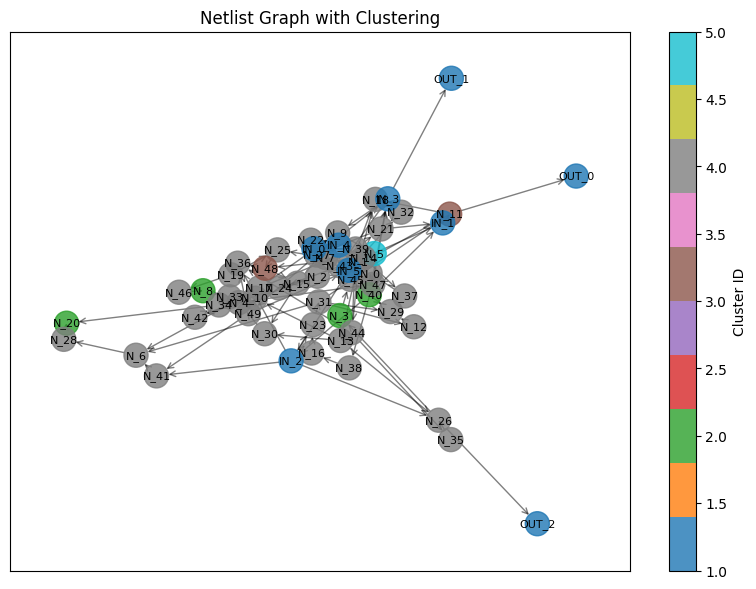

In [71]:
# Generate the netlist graph
graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)

# Perform clustering and get the cluster mapping
graph, cluster_dict = perform_agglomerative_clustering(graph)

# Compute edge cuts and wire length
edge_cuts, total_wire_length = calculate_wire_cut_and_length(graph, cluster_dict)

# Compute critical path before scaling
critical_path_before, delay_before = find_critical_path(graph)

# Update distances for inter-cluster edges
for u, v in graph.edges():
    if cluster_dict.get(u) != cluster_dict.get(v):
        graph[u][v]['distance'] *= 10

# Compute critical path after scaling
critical_path_after, delay_after = find_critical_path(graph)

# Print results
print(f"Number of Edge Cuts: {edge_cuts}")
print(f"Total Wire Length: {total_wire_length}")
print(f"Critical Path Before Scaling: {critical_path_before}")
print(f"Critical Path Delay Before Scaling: {delay_before}")
print(f"Critical Path After Scaling: {critical_path_after}")
print(f"Critical Path Delay After Scaling: {delay_after}")

# Visualize the clusters
visualize_clusters(graph, cluster_dict)